# Image exploration and analysis

<img height="240" src="../Graphics/EDA/sample 744.png" width="240"/>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import os
import seaborn as sns
sns.set()
import re
from utils import ImageDataset, split_data
import tensorflow as tf

### Read images and metadata

In [53]:
imagepath = r'C:\Users\dimka\Documents\Dermoscopy_Dataset\datasets\All BCC'

labels = pd.read_csv('labels.csv', index_col=0)
oh_labels = pd.read_csv('one_hot_labels.csv', index_col=0)
labels.sample(10)

,0
499,0
779,0
246,0
655,0
586,1
311,1
429,0
381,2
633,0
404,0


### Check the number of samples in each class

### Add the images to the dataframe

In [54]:
def str_to_numb(string_list):
    """

    :param x: list with of all the numbers
    :return: numbers missing
    """
    number_list = []
    for string in string_list:
        number = re.findall(r'\d+', string)
        number_list.append(int(number[0].strip()))
    # number_list.sort()
    return number_list

def check_for_missing_values(file_list, **kwargs):

    entries = str_to_numb(file_list)

    if 'length' in kwargs.keys:
        diff = len(entries) - kwargs['length']
    elif 'data' in kwargs.keys():
        diff = len(entries) - len(kwargs['data'])
    else:
        raise TypeError(f"At least one of 'length' or 'data' arguments must be passed")

    if diff < 0:
        print(f"There are {-diff} files missing")
    elif diff > 0:
        print(f"There are {diff} files with missing data")
    else:
        print("No files/values are missing")
        exit()

    j=0
    missing_values = []
    for entry in entries:
        if entry != (j + 1):
            missing_locally = abs(entry - (j+1))
            missing_values.append(range(missing_locally))
            j += missing_locally
        j += 1

    print(f"The")


entries = os.listdir(imagepath)
entries.sort(key=len)
img_numbers = str_to_numb(entries)
img_paths = []
j = 0
gegen = j + 1
for entry in entries:
    if img_numbers[j] == gegen:
        img_paths.append(os.path.join(imagepath, entry))
        gegen += 1
    else:
        print(f"Warning: picture {j + 1} is missing from the dataset")
        img_paths.append('None')
        img_paths.append(os.path.join(imagepath, entry))
        gegen += 2
    j += 1

df = pd.DataFrame()
df['Image Paths'] = img_paths


In [55]:
images = df['Image Paths'].values
random_images = [np.random.choice(images) for i in range(9)]

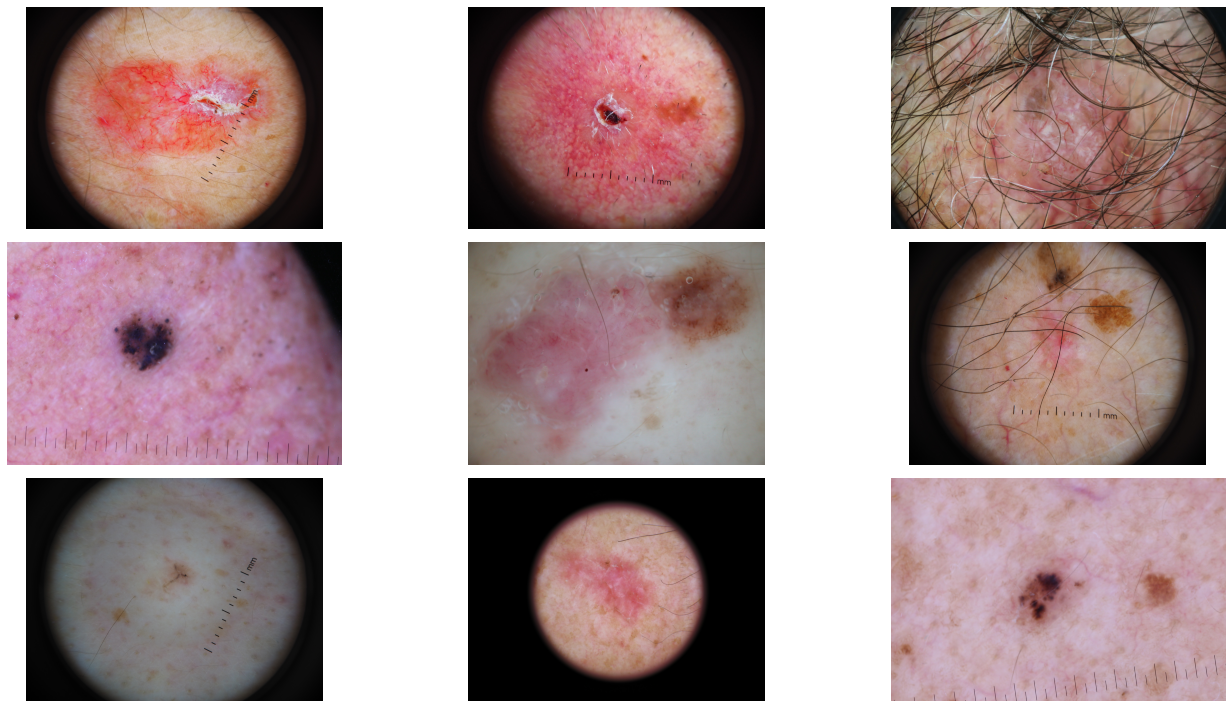

In [56]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(random_images[i])
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 3312 pixels width and 4416 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 139.1953 and the standard deviation is 31.1355


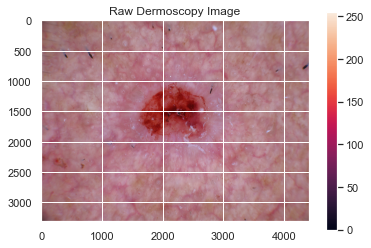

In [57]:
sample_img = df['Image Paths'][0]
raw_image = plt.imread(sample_img)
plt.imshow(raw_image)
plt.colorbar()
plt.title('Raw Dermoscopy Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

G:\My Drive\Libraries\Python\Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

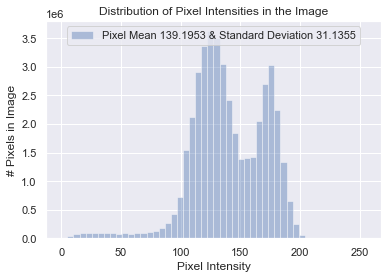

In [58]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(),
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [59]:
IMG_SHAPE = (224, 224, 3)

# import tensorflow as tf

base_model = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)
base_model.trainable = False

In [60]:
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [62]:
skf = split_data(df.loc[:800, :], labels.loc[:800, :], split_strategy='StratifiedKFold', n_splits=5, shuffle=True, random_state=1369)
preprocess_input = tf.keras.applications.resnet.preprocess_input

# image_set = ImageDataset(imagepath, entries=images, labels=labels.loc, image_type='jpg', search_type='*')
# image_set = image_set.create_image_dataset()
# image_set = ImageDataset.performance_config(image_set, cache=True, batch_size=32, prefetch=True)

In [ ]:
# import keras as krs
print(tf.__version__)

In [63]:

history = []

# img_list = list(image_set)
with tf.device("cpu:0"):
    for (train_idx, test_idx), i in skf:

        train = ImageDataset(imagepath, entries=images[train_idx], labels=oh_labels.loc[train_idx, :], image_type='jpg', search_type='*')
        test = ImageDataset(imagepath, entries=images[test_idx], labels=oh_labels.loc[test_idx, :], image_type='jpg', search_type='*')
        # train = tf.data.Dataset.from_tensor_slices([img_list[i] for i in train_idx])
        # test = tf.data.Dataset.from_tensor_slices([img_list[i] for i in test_idx])

        train = train.create_image_dataset()
        test = test.create_image_dataset()

        train = ImageDataset.performance_config(train, cache=True, batch_size=32, prefetch=True)
        test = ImageDataset.performance_config(test, cache=True, batch_size=32, prefetch=True)

        for image_batch, labels_batch in train:
            print(image_batch.shape)
            print(labels_batch.shape)
            break

        print('Defined train and test sets')
        image_batch, label_batch = next(iter(train))
        feature_batch = base_model(image_batch)
        print(feature_batch.shape)
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        feature_batch_average = global_average_layer(feature_batch)

        print("Reached model definition")
        inputs = tf.keras.Input(shape=IMG_SHAPE)
        # x = data_augmentation(inputs)
        x = preprocess_input(inputs)
        x = base_model(x, training=False)
        x = global_average_layer(x)
        # x = tf.keras.layers.Flatten(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        print('Reached Compile')
        base_learning_rate = 0.00001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
        print('Reached Training')
        temp_hist = model.fit(train,
                                epochs=5,
                                validation_data=test)

        history.append(temp_hist)

    # clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

(32, 224, 224, 3)
(32, 3)
Defined train and test sets
(32, 7, 7, 2048)
Reached model definition
Reached Compile
Reached Training
Epoch 1/5
20/20 [==============================] - 148s 7s/step - loss: 1.0029 - accuracy: 0.5391 - auc: 0.7376 - precision: 0.5767 - recall: 0.4875 - val_loss: 0.8063 - val_accuracy: 0.6335 - val_auc: 0.8117 - val_precision: 0.6512 - val_recall: 0.5217
Epoch 2/5
20/20 [==============================] - 139s 7s/step - loss: 0.8614 - accuracy: 0.6172 - auc: 0.8000 - precision: 0.6430 - recall: 0.5516 - val_loss: 0.6501 - val_accuracy: 0.7143 - val_auc: 0.8833 - val_precision: 0.7647 - val_recall: 0.6460
Epoch 3/5
20/20 [==============================] - 137s 7s/step - loss: 0.6853 - accuracy: 0.7078 - auc: 0.8712 - precision: 0.7419 - recall: 0.6469 - val_loss: 0.5252 - val_accuracy: 0.7640 - val_auc: 0.9324 - val_precision: 0.8261 - val_recall: 0.7081
Epoch 4/5
20/20 [==============================] - 138s 7s/step - loss: 0.5783 - accuracy: 0.7594 - auc: 0.90

In [67]:
history[3].model.predict(best)

ValueError: in user code:

    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_13" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)


In [66]:

best = ImageDataset(imagepath, entries=df.loc[801, :], labels=oh_labels.loc[801, :], image_type='jpg', search_type='*')
best = best.create_image_dataset()
# test = ImageDataset.performance_config(test, cache=True, batch_size=1, prefetch=True)

In [68]:
history[3].model.predict(best)

ValueError: in user code:

    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "G:\My Drive\Libraries\Python\Environment\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_13" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)


In [70]:
j=1
for model in history:
    model.model.save(f"saved_models/v1/fold_{j}")
    j += 1

INFO:tensorflow:Assets written to: saved_models/v1/fold_1\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_1\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_2\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_2\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_3\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_3\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_4\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_4\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_5\assets


INFO:tensorflow:Assets written to: saved_models/v1/fold_5\assets


In [80]:
import json
json.dump(history[4].history, open('G:\My Drive\Education\MSc Biomedical Engineering\Thesis\Code\history4.json', 'w'))

In [81]:
history_dict = json.load(open('G:\My Drive\Education\MSc Biomedical Engineering\Thesis\Code\history.json', 'r'))